# Создание рекомендательной системы.

В современном мире, любой веб-сервис, который что-либо предлагает клиенту, хочет заранее знать, что клиенту понравится, а что нет. Именно для этой цели существуют рекомендательные системы!

В данной работе я проведу небольшое исследование с целью создания своей рекомендательной системы.

Dataset - MovieLens 100K.

Я проведу исследование датасета. Далее я применю несколько подходов к созданию РС, лучшую модель я сохраню для дальнейшего выведения в продакшен. Качество модли будет оцениваться по метрике RMSE.

# Загрузка датасета и библиотек

Библиотека surprise не у меня не устанавливается на современной версии numpy, приходится устанавливать версию 1.26.4.

In [1]:
!pip uninstall -y numpy
!pip install numpy==1.26.4

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 136.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.

In [1]:
import numpy as np
print(np.__version__)

1.26.4


Теперь можно устанавливать билиотеку surprise, она нам понадобится позже, для коллаборативной фильтрации.

In [2]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2544623 sha256=899bee64a284db6f427ff3989cbc9ae257c29064dc18665554a5e184d192ec0b
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


Установим необходимые библиотеки.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import normaltest
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
# from surprise import Dataset, Reader, SVD
# from surprise.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
import gc
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, GlobalAveragePooling1D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import joblib

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
movies = pd.read_csv('/content/drive/MyDrive/Skillfactory/Диплом/data/MovieLens 100K/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Skillfactory/Диплом/data/MovieLens 100K/ratings.csv')
tags = pd.read_csv('/content/drive/MyDrive/Skillfactory/Диплом/data/MovieLens 100K/tags.csv')

Посмотрим наши таблицы.

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


# EDA

## Проверка данных на наличие пропусков и дубликатов.

In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [46]:
movies['movieId'].nunique()

9742

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
ratings['movieId'].nunique()

9724

In [7]:
ratings['userId'].nunique()

610

In [8]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [9]:
tags['movieId'].nunique()

1572

In [10]:
tags['userId'].nunique()

58

In [11]:
ratings[['userId', 'movieId']].drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   userId   100836 non-null  int64
 1   movieId  100836 non-null  int64
dtypes: int64(2)
memory usage: 1.5 MB


In [15]:
tags[['userId', 'movieId']].drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Index: 1775 entries, 0 to 3682
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   userId   1775 non-null   int64
 1   movieId  1775 non-null   int64
dtypes: int64(2)
memory usage: 41.6 KB


Пропусков и дубликатов нигде нет.

В таблице tags мало пользователей и фильмов, не получится использовать ее в работе.

Теперь объеденим все наши таблицы в одну общую. За основу возьмем таблицу ratings.

In [6]:
ratings_movies = ratings.merge(movies, on='movieId', how='left')
ratings_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


Все значения совпали, пропуски не появились.

timestamp переведем в datetime.

In [7]:
ratings_movies['date'] = pd.to_datetime(ratings_movies['timestamp'], unit='s')

## Посмотрим на наши данные.

### Посмотрим распределение оценок по пользователям.

In [20]:
ratings_movies.groupby('userId')['rating'].count().reset_index().sort_values(by='rating', ascending=False)

,userId,rating
413,414,2698
598,599,2478
473,474,2108
447,448,1864
273,274,1346
...,...,...
441,442,20
277,278,20
146,147,20
319,320,20


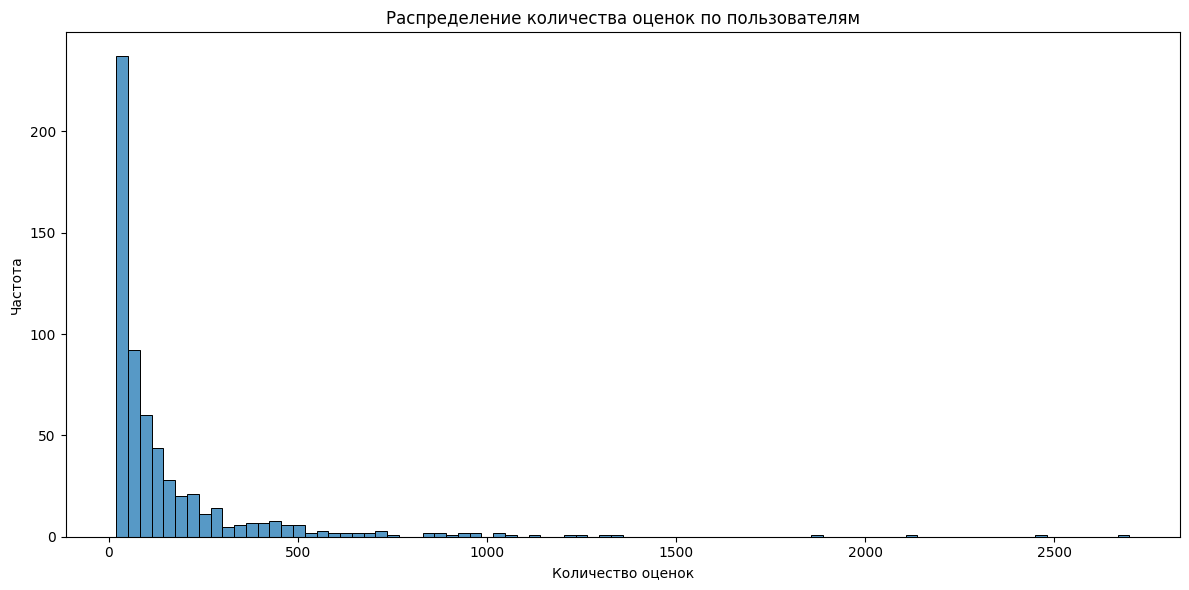

In [21]:
plt.figure(figsize=(12, 6))
sns.histplot(
    ratings_movies.groupby('userId')['rating'].count().reset_index(),
    x='rating'
)
plt.title('Распределение количества оценок по пользователям')
plt.xlabel('Количество оценок')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

По форме распределения видно, что в основном пользователи ставят мало оценок.

Описательные статистики:

In [22]:
ratings_movies.groupby('userId')['rating'].count().reset_index()['rating'].describe()

,rating
count,610.000000
mean,165.304918
std,269.480584
min,20.000000
25%,35.000000
50%,70.500000
75%,168.000000
max,2698.000000


В среднем, пользователь ставит 165 оценок, минимум 20, максимум 2698.

Давайте проанализируем поведение самого активного пользователя, может быть, это какая-то ошибка?

In [23]:
ratings_id_414 = ratings_movies[ratings_movies['userId'] == 414]
ratings_id_414

,userId,movieId,rating,timestamp,title,genres,date
62294,414,1,4.0,961438127,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000-06-19 18:08:47
62295,414,2,3.0,961594981,Jumanji (1995),Adventure|Children|Fantasy,2000-06-21 13:43:01
62296,414,3,4.0,961439278,Grumpier Old Men (1995),Comedy|Romance,2000-06-19 18:27:58
62297,414,5,2.0,961437647,Father of the Bride Part II (1995),Comedy,2000-06-19 18:00:47
62298,414,6,3.0,961515642,Heat (1995),Action|Crime|Thriller,2000-06-20 15:40:42
...,...,...,...,...,...,...,...
64987,414,180045,4.0,1515207301,Molly's Game (2017),Drama,2018-01-06 02:55:01
64988,414,180497,4.0,1525548614,The Post (2017),Drama|Thriller,2018-05-05 19:30:14
64989,414,180985,3.5,1527978072,The Greatest Showman (2017),Drama,2018-06-02 22:21:12
64990,414,184791,2.5,1519592410,Fred Armisen: Standup for Drummers (2018),Comedy,2018-02-25 21:00:10


Посмотрим активность этого пользователя по датам.

In [25]:
ratings_id_414['day'] = ratings_id_414['date'].dt.date

/tmp/ipython-input-1539031085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_id_414['day'] = ratings_id_414['date'].dt.date


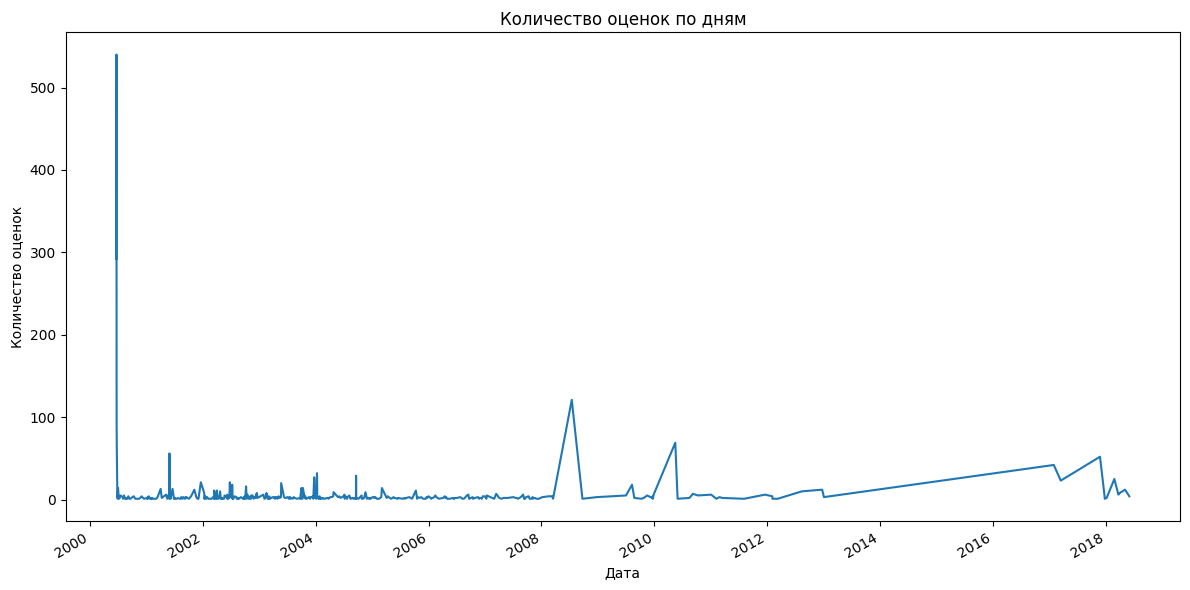

In [26]:
daily_ratings = ratings_id_414.sort_values(by='date', ascending=True).groupby('day')['rating'].count().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_ratings['day'], daily_ratings['rating'])
plt.title('Количество оценок по дням')
plt.xlabel('Дата')
plt.ylabel('Количество оценок')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

На графике видно, что наибольшую активность пользователь показывал в первые дни. Давайте детально посмотрим на активность пользователя в эти дни.

Посмотрим на первый день.

In [27]:
ratings_id_414[ratings_id_414['day'] == ratings_id_414['day'].min()].sort_values(by='date', ascending=True).iloc[:30]

,userId,movieId,rating,timestamp,title,genres,date,day
62832,414,1476,4.0,961436216,Private Parts (1997),Comedy|Drama,2000-06-19 17:36:56,2000-06-19
63270,414,2922,4.0,961436216,Hang 'Em High (1968),Crime|Drama|Western,2000-06-19 17:36:56,2000-06-19
62618,414,839,1.0,961436216,"Crow: City of Angels, The (1996)",Action|Thriller,2000-06-19 17:36:56,2000-06-19
63362,414,3253,3.0,961436216,Wayne's World (1992),Comedy,2000-06-19 17:36:56,2000-06-19
62731,414,1210,5.0,961436248,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,2000-06-19 17:37:28,2000-06-19
63246,414,2826,3.0,961436469,"13th Warrior, The (1999)",Action|Adventure|Fantasy,2000-06-19 17:41:09,2000-06-19
63049,414,2188,2.0,961436469,54 (1998),Drama,2000-06-19 17:41:09,2000-06-19
63174,414,2572,4.0,961436469,10 Things I Hate About You (1999),Comedy|Romance,2000-06-19 17:41:09,2000-06-19
63250,414,2858,5.0,961436469,American Beauty (1999),Drama|Romance,2000-06-19 17:41:09,2000-06-19
63202,414,2699,2.0,961436469,Arachnophobia (1990),Comedy|Horror,2000-06-19 17:41:09,2000-06-19


In [31]:
ratings_id_414[ratings_id_414['day'] == ratings_id_414['day'].min()]['date'].max() - ratings_id_414[ratings_id_414['day'] == ratings_id_414['day'].min()]['date'].min()

Timedelta('0 days 00:56:47')

In [32]:
ratings_id_414[ratings_id_414['day'] == ratings_id_414['day'].min()]['movieId'].nunique()

292

Пользователь поставил 292 оценки за 57 минут, получается примерно 5 оценок в минуту. Оценки разные, кажется, они вполне осознанные.

Посмотрим поведение пользователя за второй день.

In [35]:
ratings_id_414[ratings_id_414['day'] == ratings_id_414.sort_values(by='day', ascending=True).iloc[300].loc['day']].sort_values(by='date', ascending=True).iloc[:30]

,userId,movieId,rating,timestamp,title,genres,date,day
62721,414,1196,5.0,961512311,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,2000-06-20 14:45:11,2000-06-20
62527,414,527,4.0,961512311,Schindler's List (1993),Drama|War,2000-06-20 14:45:11,2000-06-20
62635,414,912,5.0,961512311,Casablanca (1942),Drama|Romance,2000-06-20 14:45:11,2000-06-20
62736,414,1217,5.0,961512311,Ran (1985),Drama|War,2000-06-20 14:45:11,2000-06-20
62727,414,1204,5.0,961512311,Lawrence of Arabia (1962),Adventure|Drama|War,2000-06-20 14:45:11,2000-06-20
62746,414,1233,5.0,961512341,"Boot, Das (Boat, The) (1981)",Action|Drama|War,2000-06-20 14:45:41,2000-06-20
62980,414,2028,5.0,961512341,Saving Private Ryan (1998),Action|Drama|War,2000-06-20 14:45:41,2000-06-20
62597,414,750,5.0,961512341,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,2000-06-20 14:45:41,2000-06-20
62755,414,1250,5.0,961512341,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War,2000-06-20 14:45:41,2000-06-20
62742,414,1224,4.0,961512341,Henry V (1989),Action|Drama|Romance|War,2000-06-20 14:45:41,2000-06-20


In [36]:
ratings_id_414[ratings_id_414['day'] == ratings_id_414.sort_values(by='day', ascending=True).iloc[300].loc['day']]['date'].max() - ratings_id_414[ratings_id_414['day'] == ratings_id_414.sort_values(by='day', ascending=True).iloc[300].loc['day']]['date'].min()

Timedelta('0 days 01:53:02')

In [37]:
ratings_id_414[ratings_id_414['day'] == ratings_id_414.sort_values(by='day', ascending=True).iloc[300].loc['day']]['movieId'].nunique()

540

За второй день этот пользователь выставил 540 оценок за 1 час 53 минуты. Получается тоже почти 5 оценок в минуту.

Видимо, данный пользователь обладает высокой насмотренностью в кино, многие фильмы ему знакомы, поэтому он может выставлять так много оценок за такой короткий срок. Если функционал сайта позволяет быстро пролистывать фильмы и выставлять оценки, то такое пользовательское поведение вполне реально.

### Посмотрим распределение оценок по фильмам.

In [10]:
ratings_movies.groupby('movieId')['rating'].count().reset_index().sort_values(by='rating', ascending=False)

,movieId,rating
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278
...,...,...
9707,190207,1
9706,190183,1
9705,189713,1
9704,189547,1


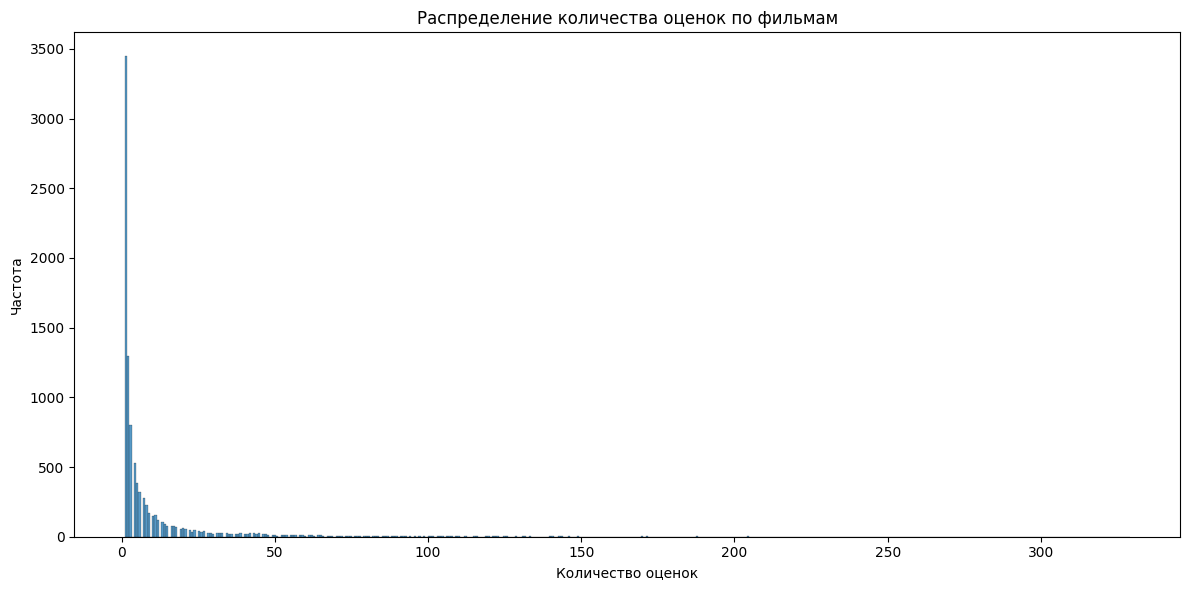

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(
    ratings_movies.groupby('movieId')['rating'].count().reset_index(),
    x='rating'
)
plt.title('Распределение количества оценок по фильмам')
plt.xlabel('Количество оценок')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

По форме графика видно, что у большенства фильмов стоит мало оценок.

Описательные статистики:

In [12]:
ratings_movies.groupby('movieId')['rating'].count().reset_index()['rating'].describe()

,rating
count,9724.000000
mean,10.369807
std,22.401005
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,329.000000


В среднем, на каждый фильм приходится 10 оценок, минимум 1, максимум 329. Процентили говорят нам о том, что оценок у фильмов мало, 75% фильмов имеет 9 или менее оценок.

Какие у нас самые поплулярные фильмы?

In [17]:
ratings_movies.groupby('movieId')['rating'].agg(['count', 'mean', 'min', 'max']).reset_index()

,movieId,count,mean,min,max
0,1,215,3.920930,0.5,5.0
1,2,110,3.431818,0.5,5.0
2,3,52,3.259615,0.5,5.0
3,4,7,2.357143,1.0,3.0
4,5,49,3.071429,0.5,5.0
...,...,...,...,...,...
9719,193581,1,4.000000,4.0,4.0
9720,193583,1,3.500000,3.5,3.5
9721,193585,1,3.500000,3.5,3.5
9722,193587,1,3.500000,3.5,3.5


In [10]:
movie_popularity = ratings_movies.groupby('movieId')['rating'].agg(['count', 'mean', 'min', 'max']).reset_index()
top_10_popular = movie_popularity.sort_values(by='count', ascending=False).iloc[:10]
top_10_popular = top_10_popular.merge(movies[['movieId', 'title']], on='movieId', how='left')
top_10_popular

,movieId,count,mean,min,max,title
0,356,329,4.164134,0.5,5.0,Forrest Gump (1994)
1,318,317,4.429022,1.0,5.0,"Shawshank Redemption, The (1994)"
2,296,307,4.197068,0.5,5.0,Pulp Fiction (1994)
3,593,279,4.161290,0.5,5.0,"Silence of the Lambs, The (1991)"
4,2571,278,4.192446,0.5,5.0,"Matrix, The (1999)"
5,260,251,4.231076,0.5,5.0,Star Wars: Episode IV - A New Hope (1977)
6,480,238,3.750000,0.5,5.0,Jurassic Park (1993)
7,110,237,4.031646,0.5,5.0,Braveheart (1995)
8,589,224,3.970982,0.5,5.0,Terminator 2: Judgment Day (1991)
9,527,220,4.225000,0.5,5.0,Schindler's List (1993)


Неплохое кино, я все это смотрел!

Давайте посмотрим, какие популярные фильмы имеют самые высокие оценки. К популярным фильмам мы отнесем те, которые стоят выше 75 процентиля по количеству оценок (9 оценок).

In [21]:
movie_popularity_val_mean = movie_popularity[movie_popularity['count'] > 9]
movie_popularity_val_mean = movie_popularity_val_mean.merge(movies[['movieId', 'title']], on='movieId', how='left')
top_10_movie_popularity_val_mean = movie_popularity_val_mean.sort_values(by='mean', ascending=False).iloc[:10]
top_10_movie_popularity_val_mean

,movieId,count,mean,min,max,title
411,1041,11,4.590909,4.0,5.0,Secrets & Lies (1996)
1186,3451,11,4.545455,3.0,5.0,Guess Who's Coming to Dinner (1967)
456,1178,12,4.541667,3.5,5.0,Paths of Glory (1957)
441,1104,20,4.475000,3.0,5.0,"Streetcar Named Desire, A (1951)"
871,2360,12,4.458333,3.0,5.0,"Celebration, The (Festen) (1998)"
484,1217,15,4.433333,3.5,5.0,Ran (1985)
158,318,317,4.429022,1.0,5.0,"Shawshank Redemption, The (1994)"
377,951,14,4.392857,3.5,5.0,His Girl Friday (1940)
722,1927,10,4.350000,3.5,5.0,All Quiet on the Western Front (1930)
1190,3468,18,4.333333,3.0,5.0,"Hustler, The (1961)"


Тут я большенства фильмов не знаю.

Давайте проверим, есить ли значимые различия в сердних оценках популярных и непопулярных фильмов. Популярными мы будем считать фильмы выше 75 процентиля, непопулярными - ниже 25.

In [40]:
low_movie_popularity = movie_popularity[movie_popularity['count'] <= movie_popularity['count'].quantile(0.25)]
high_movie_popularity = movie_popularity[movie_popularity['count'] >= movie_popularity['count'].quantile(0.75)]

In [52]:
print('Средняя оцнека непопулярных фильмов:', round(low_movie_popularity['mean'].mean(), 3))
print('Средняя оцнека популярных фильмов:', round(high_movie_popularity['mean'].mean(), 3))

Средняя оцнека непопулярных фильмов: 3.233
Средняя оцнека популярных фильмов: 3.42


Сравнение средних показывает, что популярные фильмы оценивают выше, но можно ли считать эти различия значимыми?

Давайте посмотрим на распределение наших выборок.

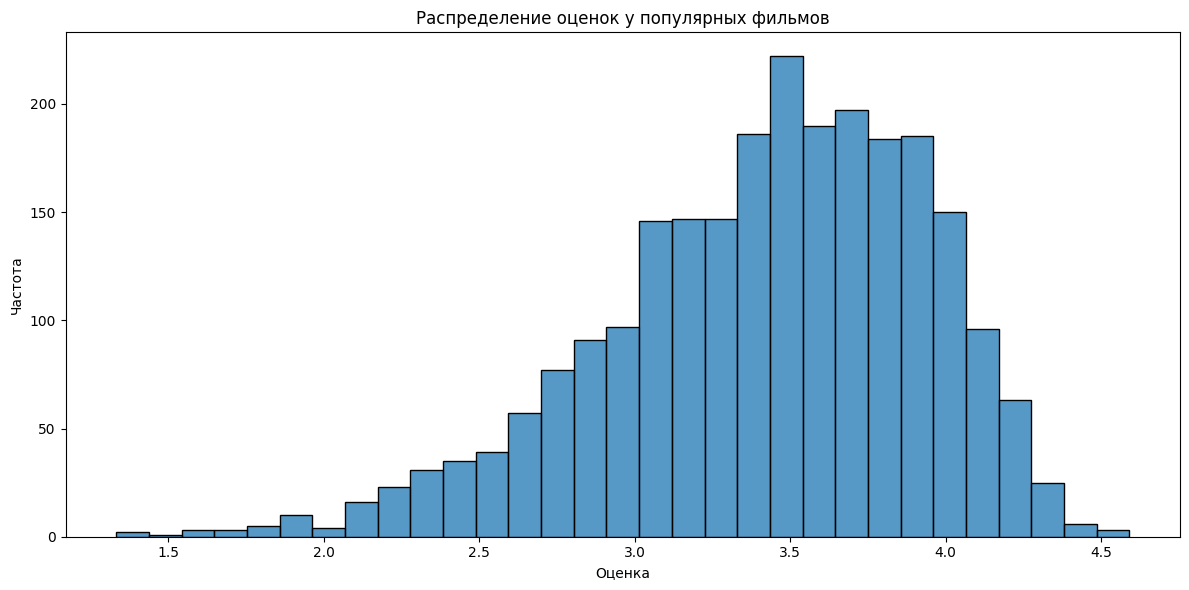

In [44]:
plt.figure(figsize=(12, 6))
sns.histplot(
    high_movie_popularity,
    x='mean'
)
plt.title('Распределение средних оценок у популярных фильмов')
plt.xlabel('Оценка')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

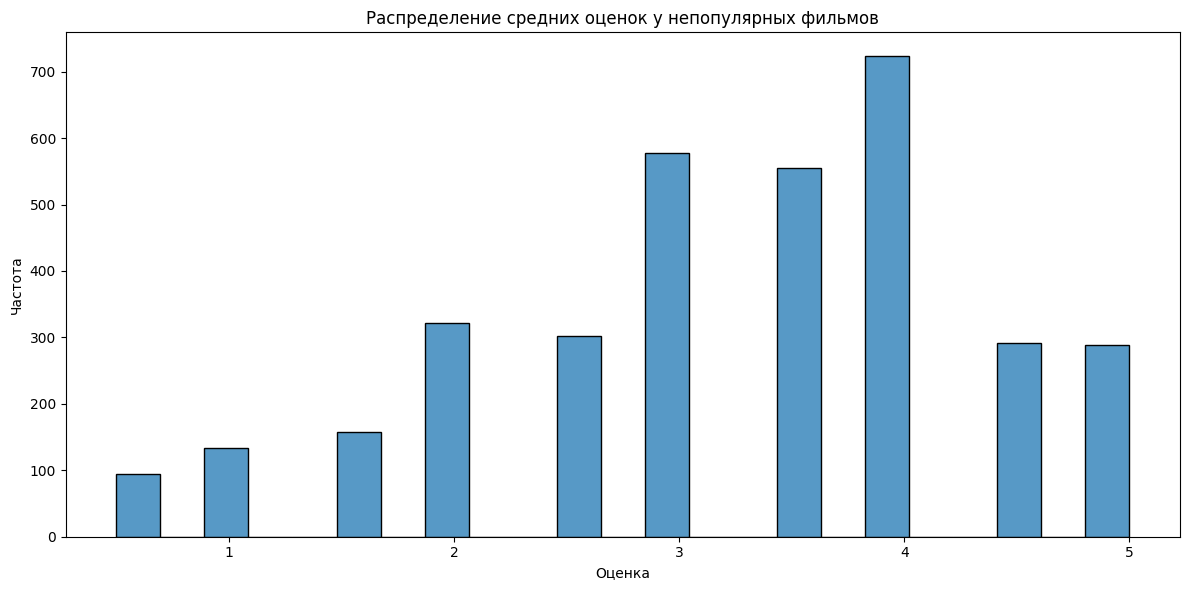

In [45]:
plt.figure(figsize=(12, 6))
sns.histplot(
    low_movie_popularity,
    x='mean'
)
plt.title('Распределение средних оценок у непопулярных фильмов')
plt.xlabel('Оценка')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Проверим выборки на нормальность тестом Шапиро — Уилка.

In [46]:
_, p = stats.shapiro(high_movie_popularity['mean'])

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= 0.05:
    print('У популярных фильмов распределение не нормальное')
else:
    print('У популярных фильмов распределение нормальное')

_, p = stats.shapiro(low_movie_popularity['mean'])

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= 0.05:
    print('У непопулярных фильмов распределение не нормальное')
else:
    print('У непопулярных фильмов распределение нормальное')

p-value = 0.000
У популярных фильмов распределение не нормальное
p-value = 0.000
У непопулярных фильмов распределение не нормальное


Тест показал, что в обоих случая распределение отлично от нормального. В таком случае, для сравнения двух независимых выборок используем непараметрический тест, а именно U-критерий Манна — Уитни.

* Нулевая гипотеза: распределения средних оценок поплярных и непопулярных фильмов одинаковы.
* Альтернативная гипотеза: распределения средних оценок поплярных и непопулярных фильмов неодинаковы.

In [47]:
# проводим тест
_, p = stats.mannwhitneyu(high_movie_popularity['mean'], low_movie_popularity['mean'])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= 0.05:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(0.05))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(0.05))

p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Отлично, тест показал, что между выборками есть значимые различия. Теперь давайте выясним, какие фильмы в среднем оценивают выше.

* Нулевая гипотеза: популярные фильмы, в среднем, оценивают так же, или хуже, чем непопулярные.
* Альтернативная гипотеза: популярные фильмы, в среднем, оценивают выше, чем непопулярные.

In [54]:
_, p = stats.mannwhitneyu(low_movie_popularity['mean'], high_movie_popularity['mean'], alternative='less')

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= 0.05:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(0.05))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(0.05))

p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Тест показал, что популярные фильмы, в среднем, оценивают достоверно выше, чем непопулярные!

### Посмотрим распределение оценок по повыборке.

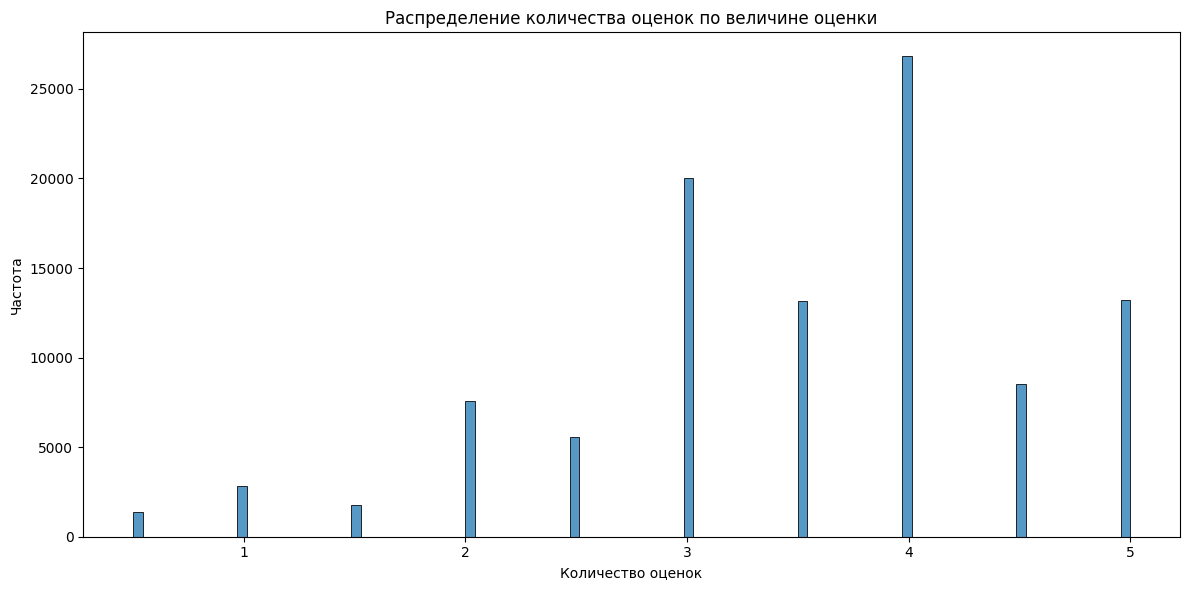

In [22]:
plt.figure(figsize=(12, 6))
sns.histplot(
    ratings_movies,
    x='rating'
)
plt.title('Распределение количества оценок по величине оценки')
plt.xlabel('Количество оценок')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

По распределению видно, что у пользователи склонны ставить высокие оценки. Самая частая оценка 4.

Описательные статистики:

In [23]:
ratings_movies['rating'].describe()

,rating
count,100836.000000
mean,3.501557
std,1.042529
min,0.500000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


Среднаяя оценка 3.5, минимальная оценка 0.5, максимальная 5.

Кстати, у нас среднее арифметическое и 50 процентиль (медиана) равны, это признак нормального распределения, давайте сейчас проверим это.

Для начала построим квантиль-квантиль график, который показывает, насколько распределение выборки близко к нормальному.

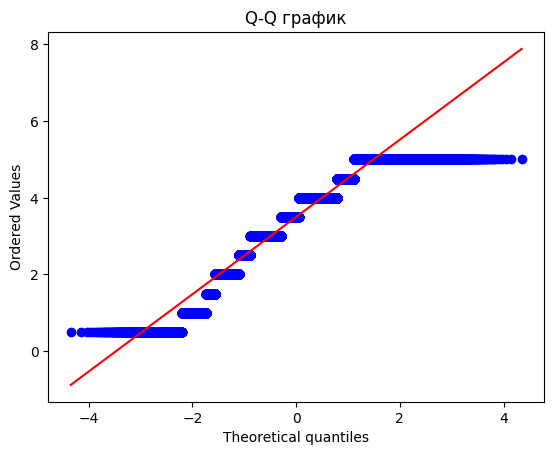

In [26]:
# Q‑Q график (сравнение с нормальным распределением)

stats.probplot(ratings_movies['rating'], dist="norm", plot=plt)
plt.title("Q‑Q график")
plt.show()

По квантиль-квантиль графику видно, что наше распределение отлично от нормального - наше распределение не лежит на диагональной линии.

Применим тест Шапиро — Уилка с уровнем значимости 0.05. Нулевая гипотеза - данные распределены нормально, альтернативная гипотеза - распределение отлично от нормального.

In [25]:
_, p = stats.shapiro(ratings_movies['rating'])

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.000
Распределение не нормальное


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100836.
  res = hypotest_fun_out(*samples, **kwds)


Тест показал, что распределение отлично от нормального, но тест Шапиро — Уилка не очень подходит для таких больших выборок, как у нас.

Для подстраховки применим Д’Агостино‑Пирсона, он подходит для больших выборок.

In [29]:
stat, p = normaltest(ratings_movies['rating'])

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.000
Распределение не нормальное


Последний тест подтвердил, что наше распределение не нормальное.

Посмотрим активность пользователей во времени.

In [32]:
ratings_movies['day'] = ratings_movies['date'].dt.date

In [40]:
ratings_movies.groupby('day')['rating'].count().sort_values(ascending=False)

,rating
day,
2017-06-26,1014
2007-05-14,878
2017-05-03,866
2000-08-08,709
2015-06-28,606
...,...
2010-01-02,1
2009-12-28,1
2010-02-01,1


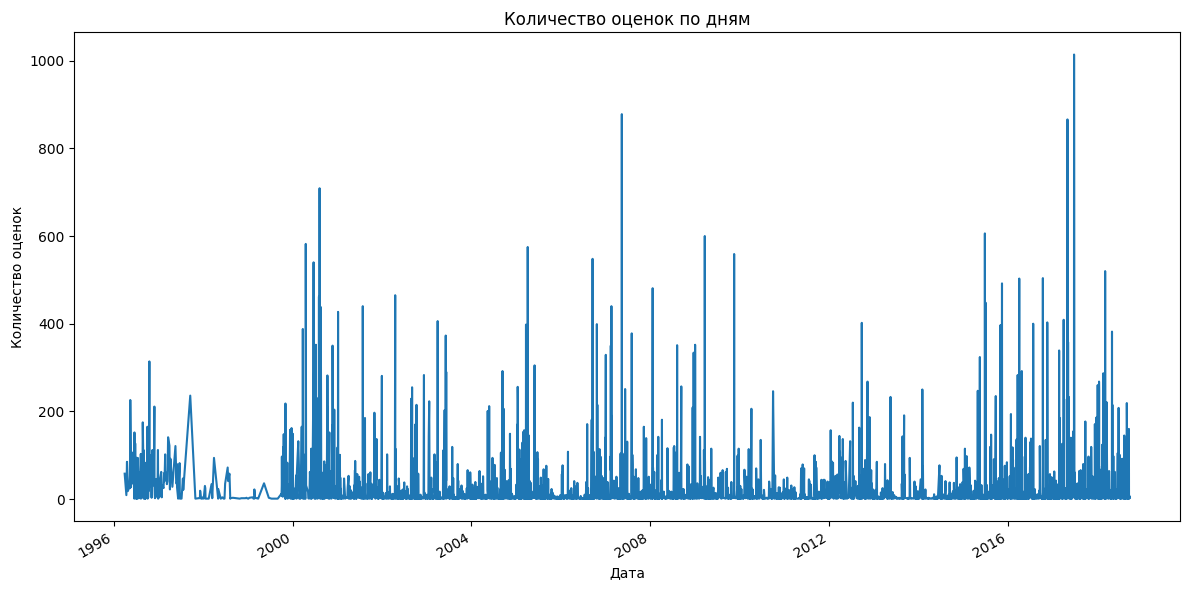

In [37]:
daily_ratings = ratings_movies.sort_values(by='date', ascending=True).groupby('day')['rating'].count().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_ratings['day'], daily_ratings['rating'])
plt.title('Количество оценок по дням')
plt.xlabel('Дата')
plt.ylabel('Количество оценок')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

По графику видно, что активность пользователей растет со временем.

### Посмотрим на жанры.

Преобразуем наши жанры в отдельные столбцы.

In [7]:
ratings_movies['genres'] = ratings_movies['genres'].str.split('|') # Преобразуем нашу строку с жанрами в список

genres_df_encoder = MultiLabelBinarizer() # Кодируем жарны
genres_df_features = genres_df_encoder.fit_transform(ratings_movies['genres'])

In [11]:
genres_df = pd.DataFrame(data=genres_df_features, columns=genres_df_encoder.classes_) # Создаем dataframe с жанрами
genres_df

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
100832,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
100833,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
100834,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Посмотрим на популярность жанров.

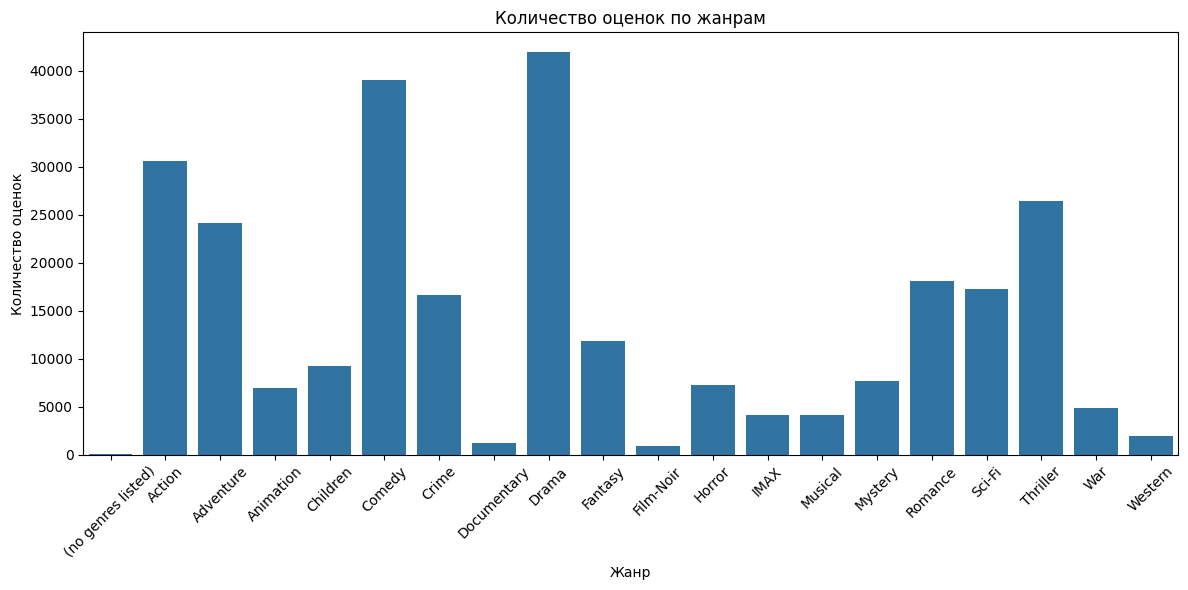

In [23]:
plt.figure(figsize=(12, 6))
sns.barplot(
    genres_df.sum()
)
plt.title('Количество оценок по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Количество оценок')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

По графику видно, что самые популярные жанры - это драма, комедия и экшн.

Теперь давайте посмотрим средний рейтинг для каждого жанра.

In [37]:
ratings_movies_genres = pd.concat([ratings_movies, genres_df], axis=1) # Объеденям две таблицы
ratings_movies_genres.head()

,userId,movieId,rating,timestamp,title,genres,date,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",2000-07-30 18:45:03,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,964981247,Grumpier Old Men (1995),"[Comedy, Romance]",2000-07-30 18:20:47,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,964982224,Heat (1995),"[Action, Crime, Thriller]",2000-07-30 18:37:04,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",2000-07-30 19:03:35,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",2000-07-30 18:48:51,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [35]:
# Считаем среднюю оценку для каждого жанра
genres_val_list = []
for genre in genres_df_encoder.classes_:
  ratings_movies_genres[genre] = ratings_movies_genres[genre]*ratings_movies_genres['rating']
  result = ratings_movies_genres[genre].sum()/genres_df[genre].sum()
  genres_val_list.append(result)

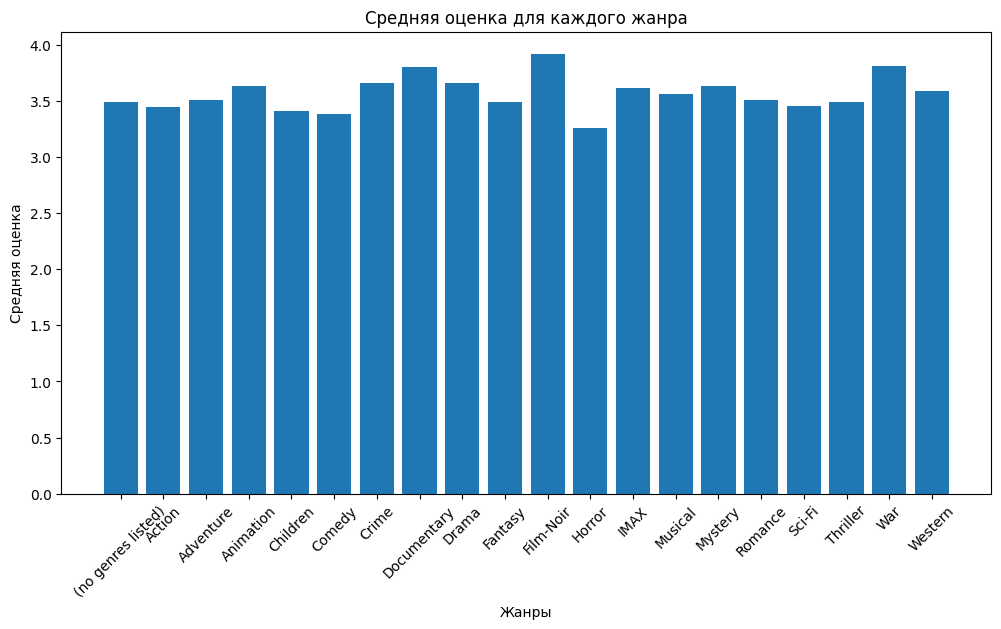

In [36]:
plt.figure(figsize=(12, 6))
plt.bar(genres_df_encoder.classes_, genres_val_list)

plt.xlabel('Жанры')
plt.ylabel('Средняя оценка')
plt.title('Средняя оценка для каждого жанра')

plt.xticks(rotation=45)

plt.show()

По графику видно, что ни один жарн сильно не выделяется. Самая высокая средняя оценка у нуара, самая низкая у ужастиков.

# Построение моделей

## Разбиение выборки на train и test.

Будем проводить разбиение по времени. Алгоритм следующий:
1. Сортируем наш датасет по пользователям и времени выставления оценки.
2. Для каждого пользователя разносим первые 80% оценок в train и последние 20% в test.

Такое разбиение позволяет создать ситуацию, близкую к реальной, когда когда мы пытаемся предсказать будущее поведение пользователя. Более того, такое разбиение гарантирует, что каждый пользователь попадет и в train и в test.

In [8]:
def temporal_train_test_split(df, test_size=0.2):
    """
    Временное разделение: для каждого пользователя последние test_size% оценок идут в test
    """
    df_sorted = df.sort_values(['userId', 'timestamp'])

    train_data = []
    test_data = []

    for user_id in df['userId'].unique():
        user_ratings = df_sorted[df_sorted['userId'] == user_id]

        split_idx = int(len(user_ratings) * (1 - test_size))

        train_data.append(user_ratings.iloc[:split_idx])
        test_data.append(user_ratings.iloc[split_idx:])

    train_df = pd.concat(train_data)
    test_df = pd.concat(test_data)

    return train_df, test_df

# Разделение данных
print("Разделение данных на train/test...")
train_df, test_df = temporal_train_test_split(ratings_movies, test_size=0.2)

print(f"Train размер: {len(train_df)}")
print(f"Test размер: {len(test_df)}")
print(f"Уникальные пользователи в train: {train_df['userId'].nunique()}")
print(f"Уникальные пользователи в test: {test_df['userId'].nunique()}")

Разделение данных на train/test...
Train размер: 80419
Test размер: 20417
Уникальные пользователи в train: 610
Уникальные пользователи в test: 610


## Baseline

В качестве бейзлайна мы будем будем использовать среднюю оценку фильма.

In [13]:
movie_popular_train = train_df.groupby('movieId')['rating'].agg(['count', 'mean']).reset_index()
movie_popular_train.head()

,movieId,count,mean
0,1,201,3.915423
1,2,92,3.413043
2,3,41,3.280488
3,4,4,2.125000
4,5,39,3.025641


Получим предсказания.

In [14]:
def non_personal_predict_model(test_data, popular_train):
  pred = []
  for movie in test_data['movieId']:
    if movie in popular_train['movieId'].to_list():
      temp_pred = popular_train[popular_train['movieId'] == movie]['mean'].iloc[0]
      pred.append(temp_pred)
    else:
      pred.append(popular_train['mean'].mean())
  return pred

In [15]:
non_personal_predict = non_personal_predict_model(test_df, movie_popular_train)

Оценим качество по метрике RMSE.

In [16]:
# RMSE

def rmse_sklearn(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

print('RMSE ', rmse_sklearn(test_df['rating'], non_personal_predict))

RMSE  1.0189099636039278


## Collaborative Filtering Model (SVD)

Идея коллаборативной фильтрации проста: поведение группы пользователей применяется для составления рекомендаций другим пользователям. Используя этот метод, мы можем прогнозировать рейтинги на основе оценок похожих пользователей или похожих продуктов.

Я выбираю коллаборативную фильтрацию на основе модели, так как, такой подход ускоряет работу системы.

В подходе на основе моделей используются модели машинного обучения для прогнозирования и ранжирования взаимодействий между пользователями и элементами, с которыми они ещё не взаимодействовали. Эти модели обучаются на основе информации, уже имеющейся в матрице взаимодействий, с помощью различных алгоритмов, например матричной факторизации.

В данном случае, мы будем применять матричную факторизацию SVD. Для построения модели будем использовать библиотеку surprise.

In [18]:
reader = Reader(rating_scale=(0.5, 5.0))
train_surprise = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
trainset = train_surprise.build_full_trainset()

svd = SVD()
svd.fit(trainset)
testset = [(row['userId'], row['movieId'], row['rating']) for _, row in test_df.iterrows()]
cf_predictions = [svd.predict(uid, iid).est for (uid, iid, _) in testset]

Оценим качество модели по метрике RMSE.

In [19]:
print('RMSE ', rmse_sklearn(test_df['rating'], cf_predictions))

RMSE  0.895115917019487


Попробуем подобрать гиперпараметры для улучшения метрики.

In [20]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)


param_grid = {
        'n_factors': [50, 100, 150],
        'n_epochs': [20, 30],
        'lr_all': [0.002, 0.005, 0.01],
        'reg_all': [0.02, 0.04, 0.06],
        'random_state': [42]
    }

gs = GridSearchCV(
    SVD,
    param_grid,
    measures=['rmse', 'mae'],
    cv=5,
    n_jobs=-1,
    refit=True
)

gs.fit(data)

print("Лучшие параметры RMSE:", gs.best_params['rmse'])
print("Лучший RMSE:", gs.best_score['rmse'])


Лучшие параметры RMSE: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.06, 'random_state': 42}
Лучший RMSE: 0.8587103881649115


Обучим модель на лучших параметрах.

In [20]:
svd_opt = SVD(n_factors=150, n_epochs=30, lr_all=0.01, reg_all=0.06, random_state=42)
svd_opt.fit(trainset)
testset = [(row['userId'], row['movieId'], row['rating']) for _, row in test_df.iterrows()]
cf_predictions = [svd_opt.predict(uid, iid).est for (uid, iid, _) in testset]

print('RMSE ', rmse_sklearn(test_df['rating'], cf_predictions))

RMSE  0.8724377979378624


Улучшение RMSE примерно на 0.02, это неплохо.

#### Сравнение с Baseline.

Напишем функцию, которая будем выводить распределение квадратов ошибок и проводить статистический теста на наличине значимых различий в квадратах ошибок между Baseline и другой моделью.

В качесвте статистического теста мы возьмем U-критерий Манна — Уитни, так как распределение квадрата ошибка не может быть нормальным.

Гипотезы:
* Нулевая гипотеза: средний квадрат ошибки модели больше или равен среднему квадрату ошибка Baseline.
* Альтернативная гипотеза: средний квадрат ошибки модели меньше среднего квадрата ошибки Baseline.

In [58]:
def stat_analysis(temp_prediction, baseline=non_personal_predict):
  baseline_error = (baseline - test_df['rating'])**2
  model_error = (temp_prediction - test_df['rating'])**2

  plot_df = pd.DataFrame({
      'Квадрат ошибки': list(baseline_error)+list(model_error),
      'Группы': ['baseline_error']*len(baseline_error) + ['model_error']*len(model_error)
  })
  plt.figure(figsize=(12, 6))
  sns.histplot(
      plot_df,
      x='Квадрат ошибки',
      hue='Группы',
      bins=150
  )
  plt.title('Распределение ошибки')
  plt.xlabel('Величина ошибки')
  plt.ylabel('Частота')

  plt.tight_layout()
  plt.show()

  # Используем непараметрический критерий, так как распределение квдарата ошибки отлично от нормального
  _, p = stats.mannwhitneyu(model_error,
                            baseline_error,
                            alternative='less'
                            )

  print('p-value = {:.3f}'.format(p))

  # интерпретируем результат
  if p <= 0.05:
      print('p-значение меньше, чем заданный уровень значимости {:.2f}. Наша модель дает значимо меньший квадрат ошибки, чем Baseline.'.format(0.05))
  else:
      print('p-значение больше, чем заданный уровень значимости {:.2f}. Наша модель не дает значимо меньший квадрат ошибки, чем Baseline.'.format(0.05))

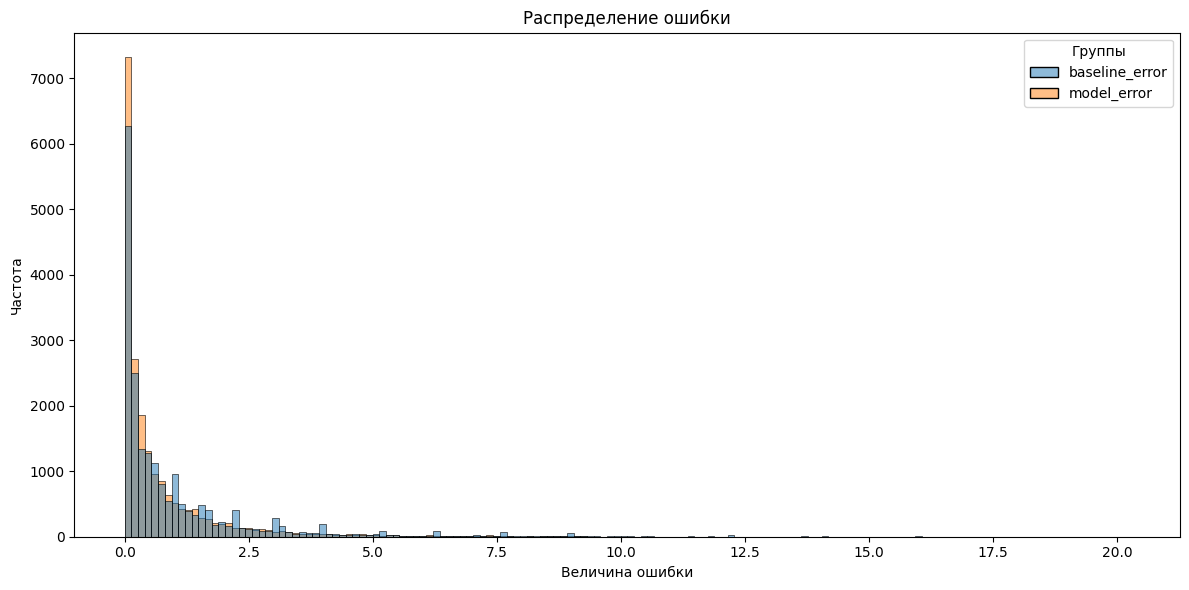

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Наша модель дает значимо меньший квадрат ошибки, чем Baseline.


In [57]:
stat_analysis(cf_predictions)

U-критерий Манна — Уитни показал, что наша модель SVD дает значимо меньший квадрат ошибки, чем Baseline, это хорошо.

## Content-dased

Подход content-based предполагает, что пользователю рекомендуются товары или контент на основе его предпочтений и вкусов.

Для каждого пользователя формируется профиль оценок по жанрам. Для предсказания оценки фильма, берутся жанры конкретного фильма, соотносятся с профилем пользователя, и берется средняя оценка.

К примеру, мы пытаемся предсказать рейтинг фильма с жанрами Action и Children. Наш пользователь оценивает жанр Action на 4, а жанр Children на 3. Таким образом, предсказанная оценка будет равна (4+3)/2 = 3.5.

Подготваливаем данные для CB РС.

In [21]:
train_exploded = train_df.explode('genres')
user_genre_avg = train_exploded.groupby(['userId', 'genres'])['rating'].mean().unstack()

movie_to_genres = movies.set_index('movieId')['genres'].str.split('|').to_dict()

global_avg = train_df['rating'].mean()

In [27]:
global_avg

3.513013093920591

In [22]:
def content_based_predict(user_id, movie_id):
    genres = movie_to_genres.get(movie_id, [])
    if not genres:
        return global_avg
    try:
        user_avg = user_genre_avg.loc[user_id]
    except KeyError:
        return global_avg
    valid_ratings = [user_avg[g] for g in genres if g in user_avg and not np.isnan(user_avg[g])]
    return np.mean(valid_ratings) if valid_ratings else global_avg

Посчитаем предсказание, и качество модели.

In [23]:
cb_predictions = test_df.apply(lambda row: content_based_predict(row['userId'], row['movieId']), axis=1)
print('RMSE ', rmse_sklearn(test_df['rating'], cb_predictions))

RMSE  0.9430916293283343


#### Сравнение с Baseline.

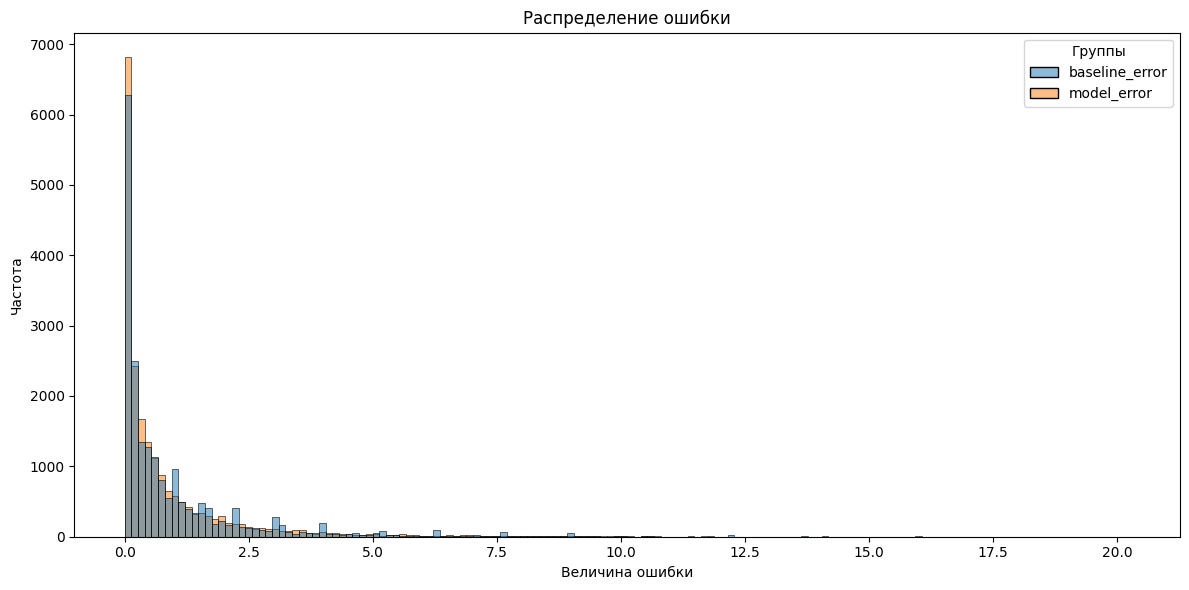

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Наша модель дает значимо меньший квадрат ошибки, чем Baseline.


In [59]:
stat_analysis(cb_predictions)

U-критерий Манна — Уитни показал, что наша модель Content-dased дает значимо меньший квадрат ошибки, чем Baseline, это хорошо.

## Гибридная модель - Content-based & Collaborative filtering.

Будем рассчитывать средневзвешенное значение результатов двух моделей, Content-based & Collaborative filtering.

Подберем лучшее соотношение.

In [24]:
rmse_list = []
for i in np.arange(0, 1.0, 0.1):
  cf_cd_hybrid_predictions = np.array(cf_predictions) * (1 - i) + np.array(cb_predictions) * i
  rmse_list.append(rmse_sklearn(test_df['rating'], cf_cd_hybrid_predictions))

Получим предсказания, которые дали самую маленькую ошибку по метрике RMSE.

In [25]:
i = np.arange(0, 1.0, 0.1)[rmse_list.index(min(rmse_list))]
cf_cd_hybrid_predictions = np.array(cf_predictions) * (1 - i) + np.array(cb_predictions) * i

print('RMSE ', rmse_sklearn(test_df['rating'], cf_cd_hybrid_predictions))
print('i =', i)

RMSE  0.8702237541743084
i = 0.2


Гибридная модель улучшает метрику на 0.002.

#### Сравнение с Baseline.

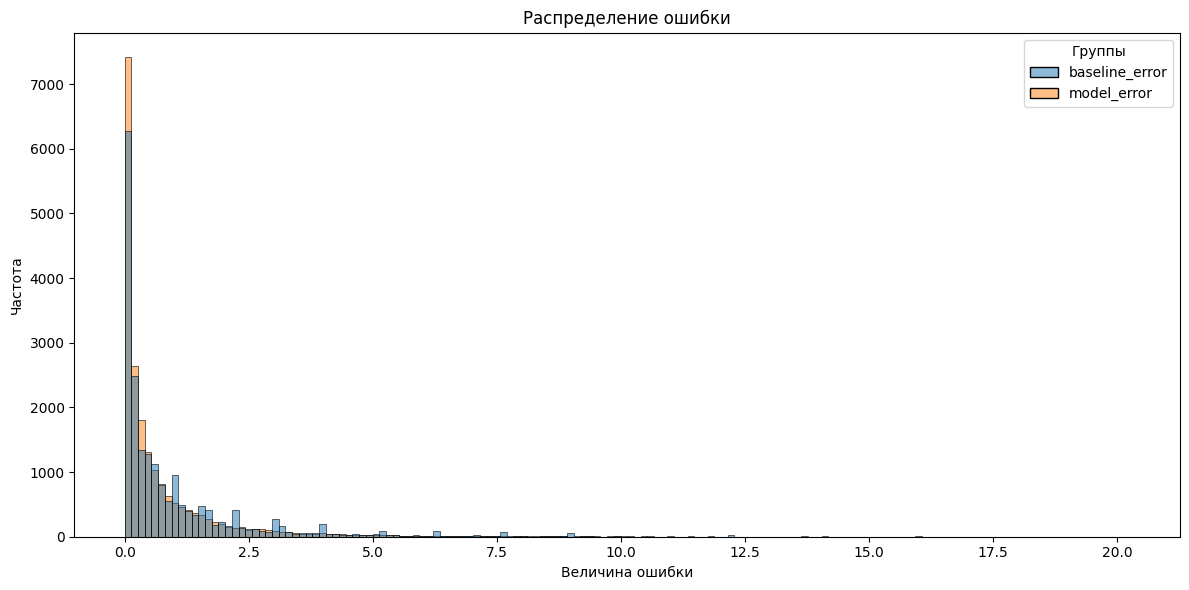

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Наша модель дает значимо меньший квадрат ошибки, чем Baseline.


In [61]:
stat_analysis(cf_cd_hybrid_predictions)

U-критерий Манна — Уитни показал, что наша Гибридная модель дает значимо меньший квадрат ошибки, чем Baseline, это хорошо.

## Two-tower embedding models

В качестве входных данных для нейронной сети мы передаём вектор характеристик пользователя и вектор для фильма.

Из обоих этих векторов получаются эмбеддинги. Далее эти эмбеддинги проходят через несколько полносвязных слоёв, на выходе из которых они преобразуются в предсказание.

In [66]:
train_DL = train_df.copy()
test_DL = test_df.copy()

Для корректной работы эмбедингов, данные надо упорядочить, для этого воспользуемся LabelEncoder.

In [67]:
# Перекодируем ID в непрерывную последовательность от 0 до n-1

# Для movieId
movie_encoder = LabelEncoder()
movie_encoder.fit(ratings['movieId'])
n_movies = len(movie_encoder.classes_)
train_DL['movieId_encoded'] = movie_encoder.transform(train_DL['movieId'])
test_DL['movieId_encoded'] = movie_encoder.transform(test_DL['movieId'])

# Для userId
user_encoder = LabelEncoder()
user_encoder.fit(ratings['userId'])
n_users = len(user_encoder.classes_)
train_DL['userId_encoded'] = user_encoder.transform(train_DL['userId'])
test_DL['userId_encoded'] = user_encoder.transform(test_DL['userId'])

Теперь соберем нейросеть.

In [68]:
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_movies, 32, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Movie")(movie_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users, 32, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

conc = Concatenate()([movie_vec, user_vec])

fc1 = Dense(512, activation='relu')(conc)
fc1 = BatchNormalization()(fc1)  # Batch Normalization
fc1 = Dropout(0.3)(fc1)  # Dropout
fc2 = Dense(256, activation='relu')(fc1)
fc2 = BatchNormalization()(fc2)  # Batch Normalization
fc2 = Dropout(0.3)(fc2)  # Dropout
fc3 = Dense(128, activation='relu')(fc2)
fc3 = BatchNormalization()(fc3)  # Batch Normalization
fc3 = Dropout(0.3)(fc3)  # Dropout
fc4 = Dense(32, activation='relu')(fc3)
fc4 = BatchNormalization()(fc4)
fc4 = Dropout(0.3)(fc4)
out = Dense(1)(fc4)
out = tf.keras.layers.Lambda(lambda x: x * 4.5 + 0.5)(out)

two_tower_model = Model([user_input, movie_input], out)

two_tower_model.compile(optimizer = 'adam',loss =  'mean_squared_error',
               metrics=[
                  'mae',
                  tf.keras.metrics.RootMeanSquaredError(name='rmse')]
              )

In [69]:
two_tower_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Movie-Input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User-Input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Movie-Embedding     │ (None, 1, 32)     │    311,168 │ Movie-Input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User-Embedding      │ (None, 1, 32)     │     19,520 │ User-Input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten-Movie       │ (None, 32)        │          0 │ Movie-Embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten-Users       │ (None, 32)        │          0 │ User-Embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ Flatten-Movie[0]… │
│ (Concatenate)       │                   │            │ Flatten-Users[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │     33,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      4,128 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 536,065 (2.04 MB)

 Trainable params: 534,209 (2.04 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [70]:
history = two_tower_model.fit(
    [train_DL.userId_encoded, train_DL.movieId_encoded], train_DL.rating, epochs=5, verbose=1,
    validation_data=([test_DL.userId_encoded, test_DL.movieId_encoded], test_DL.rating)
    )

Epoch 1/5
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - loss: 8.7210 - mae: 1.9617 - rmse: 2.7538 - val_loss: 1.0598 - val_mae: 0.8026 - val_rmse: 1.0295
Epoch 2/5
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 97s 23ms/step - loss: 0.9728 - mae: 0.7771 - rmse: 0.9862 - val_loss: 0.8572 - val_mae: 0.7145 - val_rmse: 0.9259
Epoch 3/5
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 61s 14ms/step - loss: 0.7758 - mae: 0.6800 - rmse: 0.8808 - val_loss: 0.8336 - val_mae: 0.7015 - val_rmse: 0.9130
Epoch 4/5
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 0.7276 - mae: 0.6582 - rmse: 0.8530 - val_loss: 0.8372 - val_mae: 0.7037 - val_rmse: 0.9150
Epoch 5/5
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.6949 - mae: 0.6410 - rmse: 0.8336 - val_loss: 0.8024 - val_mae: 0.6842 - val_rmse: 0.8957


In [71]:
# Удаляем модель и очищаем память.
del two_tower_model
tf.keras.backend.clear_session()
gc.collect()

0

До добавления Dropout и BatchNormalization слоев нейросеть переобучалась, теперь переобучения нет!

Попробуем добавить в нашу нейросеть метаданные о фильмах, а именно признак "жанры".

In [72]:
data_df = ratings_movies.copy()

In [73]:
all_genres_test = set()
for genres in data_df['genres'][:5]:
  all_genres_test.update(genres)

In [74]:
# Создаем бинарное кодирование жанров
all_genres = set()
for genres in data_df['genres']:
    all_genres.update(genres)

all_genres = sorted(list(all_genres))
n_genres = len(all_genres)

In [75]:
train_plus_g_DL = train_DL.copy()
test_plus_g_DL = test_DL.copy()

In [76]:
# Создаем бинарные векторы жанров
genre_encoder = MultiLabelBinarizer()
genre_features = genre_encoder.fit_transform(data_df['genres'])
data_df['genre_vector'] = list(genre_features)
train_plus_g_DL['genre_vector'] = list(genre_encoder.transform(train_plus_g_DL['genres']))
test_plus_g_DL['genre_vector'] = list(genre_encoder.transform(test_plus_g_DL['genres']))

In [77]:
# Подготовка данных для обучения
def prepare_genre_data(df):
    """Преобразует genre_vector в numpy array"""
    return np.array(df['genre_vector'].tolist())

X_train_genres = prepare_genre_data(train_plus_g_DL)
X_test_genres = prepare_genre_data(test_plus_g_DL)

In [78]:
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_movies, 64, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Movie")(movie_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users, 64, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

genre_input = Input(shape=[n_genres], name="Genre-Input")

conc = Concatenate()([movie_vec, user_vec, genre_input])

fc1 = Dense(512, activation='relu')(conc)
fc1 = BatchNormalization()(fc1)  # Batch Normalization
fc1 = Dropout(0.3)(fc1)  # Dropout
fc2 = Dense(256, activation='relu')(fc1)
fc2 = BatchNormalization()(fc2)  # Batch Normalization
fc2 = Dropout(0.3)(fc2)  # Dropout
fc3 = Dense(128, activation='relu')(fc2)
fc3 = BatchNormalization()(fc3)  # Batch Normalization
fc3 = Dropout(0.3)(fc3)  # Dropout
fc4 = Dense(32, activation='relu')(fc3)
fc4 = BatchNormalization()(fc4)
fc4 = Dropout(0.3)(fc4)
out = Dense(1)(fc4)
out = tf.keras.layers.Lambda(lambda x: x * 4.5 + 0.5)(out)

two_tower_model_gr = Model([user_input, movie_input, genre_input], out)

two_tower_model_gr.compile(optimizer = 'adam',loss =  'mean_squared_error',
               metrics=[
                  'mae',
                  tf.keras.metrics.RootMeanSquaredError(name='rmse')
              ])

In [79]:
two_tower_model_gr.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Movie-Input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User-Input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Movie-Embedding     │ (None, 1, 64)     │    622,336 │ Movie-Input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User-Embedding      │ (None, 1, 64)     │     39,040 │ User-Input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten-Movie       │ (None, 64)        │          0 │ Movie-Embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten-Users       │ (None, 64)        │          0 │ User-Embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Genre-Input         │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 148)       │          0 │ Flatten-Movie[0]… │
│ (Concatenate)       │                   │            │ Flatten-Users[0]… │
│                     │                   │            │ Genre-Input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │     76,288 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      4,128 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_3[0][0]   

 Total params: 909,761 (3.47 MB)

 Trainable params: 907,905 (3.46 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [80]:
history = two_tower_model_gr.fit(
    [train_DL.userId_encoded, train_DL.movieId_encoded, X_train_genres], train_DL.rating, epochs=5, verbose=1,
    validation_data=([test_DL.userId_encoded, test_DL.movieId_encoded, X_test_genres], test_DL.rating)
    )

Epoch 1/5
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - loss: 13.5774 - mae: 2.4256 - rmse: 3.4343 - val_loss: 1.0959 - val_mae: 0.8250 - val_rmse: 1.0469
Epoch 2/5
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - loss: 1.0495 - mae: 0.8162 - rmse: 1.0244 - val_loss: 0.9083 - val_mae: 0.7414 - val_rmse: 0.9531
Epoch 3/5
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - loss: 0.8386 - mae: 0.7130 - rmse: 0.9157 - val_loss: 0.8163 - val_mae: 0.6938 - val_rmse: 0.9035
Epoch 4/5
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - loss: 0.7328 - mae: 0.6600 - rmse: 0.8560 - val_loss: 0.7873 - val_mae: 0.6798 - val_rmse: 0.8873
Epoch 5/5
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 0.6889 - mae: 0.6382 - rmse: 0.8299 - val_loss: 0.7921 - val_mae: 0.6817 - val_rmse: 0.8900


Результат улучшился с добавлением жанров!

Функция, которая предсказывает оцеку фильма.

In [81]:
data_df['movieId_encoded'] = movie_encoder.transform(data_df['movieId'])
movie_data = data_df[['movieId', 'movieId_encoded', 'genres']]
movie_data['genres'] = movie_data['genres'].apply(tuple)
movie_data = movie_data.drop_duplicates()

def predict_rating(user_id, movie_id, model=two_tower_model_gr):
  try:
    user_encoded = user_encoder.transform([user_id])[0]
    movie_encoded = movie_encoder.transform([movie_id])[0]

    # Находим жанры по фильму
    movie_genres = movie_data[movie_data['movieId'] == movie_id]['genres'].iloc[0]
    genres_vector = genre_encoder.transform([movie_genres])[0]

    prediction = model.predict([
        np.array([user_encoded]),
        np.array([movie_encoded]),
        np.array([genres_vector])
    ], verbose=0)

    return prediction[0][0]
  except Exception as e:
    print(f'Ошибка предсказания: {e}')
    return None

/tmp/ipython-input-2229291469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['genres'] = movie_data['genres'].apply(tuple)


Получим предсказания для всего тестового датасета.

In [83]:
dl_predictions = test_df.apply(lambda row: predict_rating(row['userId'], row['movieId']), axis=1)

#### Сравнение с Baseline.

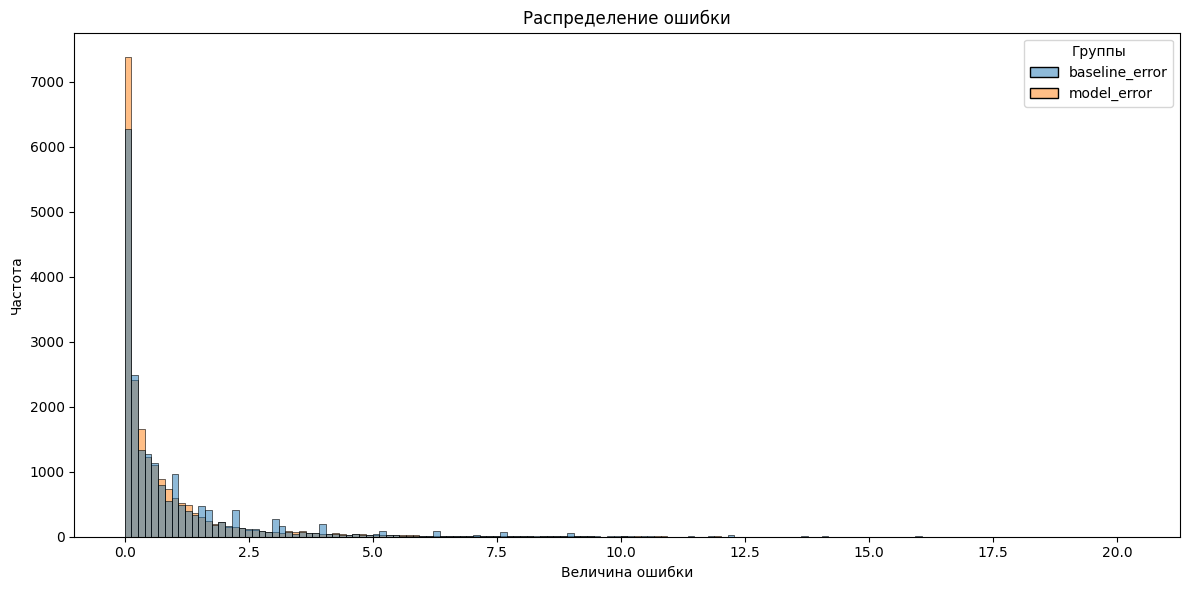

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Наша модель дает значимо меньший квадрат ошибки, чем Baseline.


In [85]:
stat_analysis(dl_predictions)

U-критерий Манна — Уитни показал, что наша Two-tower model дает значимо меньший квадрат ошибки, чем Baseline, это хорошо.

# Сравнение моделей.

Создадим DataFrame, в который запишем реальные рейтинги, и рейтинги, предсказанные каждой моделью.

In [84]:
all_test_predictions_df = pd.DataFrame(data=None, columns=['rating', 'Baseline', 'SVD', 'Content_based', 'Hybrid', 'DL'])
all_test_predictions_df['rating'] = test_df['rating']
all_test_predictions_df['Baseline'] = non_personal_predict
all_test_predictions_df['SVD'] = cf_predictions
all_test_predictions_df['Content_based'] = cb_predictions
all_test_predictions_df['Hybrid'] = cf_cd_hybrid_predictions
all_test_predictions_df['DL'] = dl_predictions

# Сохраним DataFrame
all_test_predictions_df.to_csv('/content/drive/MyDrive/Skillfactory/Диплом/data/MovieLens 100K/all_test_predictions_df.csv', index=False)

In [86]:
all_test_predictions_df = pd.read_csv('/content/drive/MyDrive/Skillfactory/Диплом/data/MovieLens 100K/all_test_predictions_df.csv')
all_test_predictions_df.head()

,rating,Baseline,SVD,Content_based,Hybrid,DL
192,5.0,4.256410,4.827544,4.311746,4.724384,4.729504
76,2.0,4.115942,4.905260,3.679487,4.660105,4.378027
91,4.0,3.500000,4.333985,3.000000,4.067188,3.961250
174,4.0,3.214286,4.059481,3.000000,3.847585,3.838001
176,5.0,3.166667,4.135710,3.913690,4.091306,3.976281
...,...,...,...,...,...,...
100612,3.5,3.000000,3.377029,3.538835,3.409390,2.860905
99540,4.0,3.436170,3.366052,3.650363,3.422914,3.636618
99556,3.5,3.000000,3.707110,3.601236,3.685935,3.116232
99681,3.5,2.687500,2.751921,3.538835,2.909303,3.141918


Так как распределение наших ошибок отлично от нормально, то для множественного сравнения будем использовать Критерий Краскела — Уоллиса.

Нулевая гипотеза: медианы квадратов ошибок разных моделей (SVD, Content-based, Hybrid, DL) равны.


Альтернативная гипотеза: медианы квадратов ошибок разных моделей (SVD, Content-based, Hybrid, DL) не равны.

In [88]:
# готовим данные
svd_error = (all_test_predictions_df['SVD'] - all_test_predictions_df['rating'])**2
cb_error = (all_test_predictions_df['Content_based'] - all_test_predictions_df['rating'])**2
hybrid_error = (all_test_predictions_df['Hybrid'] - all_test_predictions_df['rating'])**2
dl_error = (all_test_predictions_df['DL'] - all_test_predictions_df['rating'])**2

# проводим тест
_, p = stats.kruskal(svd_error, cb_error, hybrid_error, dl_error)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= 0.05:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(0.05))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(0.05))


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Мы отвергаем нолувую гипотезу, значит, между квадратами ошибок есть значимые различия.
Давайте посмотрим RMSE для каждой модели.

In [90]:
rmse_models = {
    'Model': ['SVD', 'Content_based', 'Hybrid', 'DL'],
    'RMSE': [
        rmse_sklearn(all_test_predictions_df['rating'], all_test_predictions_df['SVD']),
        rmse_sklearn(all_test_predictions_df['rating'], all_test_predictions_df['Content_based']),
        rmse_sklearn(all_test_predictions_df['rating'], all_test_predictions_df['Hybrid']),
        rmse_sklearn(all_test_predictions_df['rating'], all_test_predictions_df['DL'])
        ]
}

rmse_models_df = pd.DataFrame(rmse_models)

/tmp/ipython-input-2508438092.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=rmse_models_df, palette='magma')


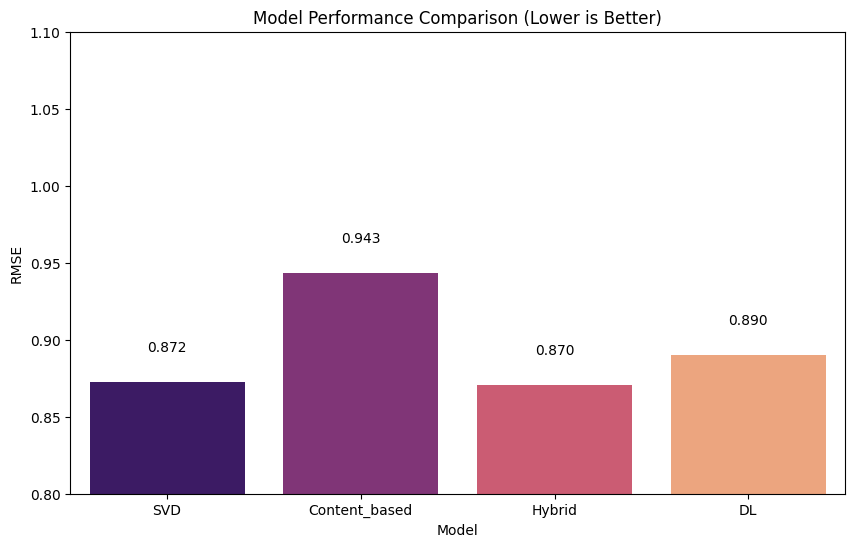

In [93]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=rmse_models_df, palette='magma')
plt.title('Model Performance Comparison (Lower is Better)')
plt.ylim(0.8, 1.1)
for index, row in rmse_models_df.iterrows():
    plt.text(index, row.RMSE+0.02, f'{row.RMSE:.3f}', ha='center')
plt.show()

По графику видно, что у модели Content-based результат заметно хуже, чем у остальных. Давайте проверим, будут ли значимые различия между моделями, если исключить из сравнения модель Content-based.

In [94]:
# проводим тест
_, p = stats.kruskal(svd_error, hybrid_error, dl_error)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= 0.05:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(0.05))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(0.05))


p-value = 0.061
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Как и ожидалось, тест показал, что медианы квадратов ошибок разных моделей (SVD, Hybrid, DL) равны.

Хотя, между моделями SVD, Hybrid и DL, нет значимых различий в значении квадрата ошибки, но минимальный RMSE показала модель Hybrid, ее мы будем выводить в продакшен.

### Получаем рекомендации от лучшей модели (Hybrid).

По метрике RMSE, лучше всех оказалась гибридная модель Content-based & Collaborative filtering.

In [33]:
def content_based_predict(user_id, movie_id):
    genres = movie_to_genres.get(movie_id, [])
    if not genres:
        return global_avg
    try:
        user_avg = user_genre_avg.loc[user_id]
    except KeyError:
        return global_avg
    valid_ratings = [user_avg[g] for g in genres if g in user_avg and not np.isnan(user_avg[g])]
    return np.mean(valid_ratings) if valid_ratings else global_avg

In [95]:
def recommendations_for_user(user_id, top_n=10, min_rating=3.5, exclude_watched=True):
  try:
    # Определяем фильмы, которые пользователь уже смотрел
    watched_movies = ratings[ratings['userId'] == user_id]['movieId'].to_list() if exclude_watched else []

    # Формируем список фильмов, которе пользователь не видел
    movies_to_recommend = [m for m in movies['movieId'].unique() if m not in watched_movies]

    predictions = []
    for movie_id in movies_to_recommend:
      # Применяем гибридную модель для расчета рейтинга фильма
      # i = 0.2 дала лучший результат на тесте
      pred_rating = svd_opt.predict(user_id, movie_id).est * (1 - 0.2) + content_based_predict(user_id, movie_id) * 0.2
      if pred_rating and pred_rating >= min_rating:
        predictions.append({
            'movieID': movie_id,
            'prediction_rating': pred_rating
        })

    recommendations = sorted(predictions, key=lambda x: x['prediction_rating'], reverse=True)

    return recommendations[:top_n]
  except Exception as e:
    print(f"Ошибка предсказания для пользователя {user_id}: {e}")
    return None

In [102]:
rec = recommendations_for_user(3)
rec_df = pd.DataFrame(rec)
rec_df = rec_df.merge(movies[['movieId', 'title']], left_on='movieID', right_on='movieId', how='left')
rec_df['title']

,title
0,Seven (a.k.a. Se7en) (1995)
1,Monty Python and the Holy Grail (1975)
2,"Maltese Falcon, The (1941)"
3,Memento (2000)
4,Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
5,Six-String Samurai (1998)
6,Dogville (2003)
7,Evil Dead II (Dead by Dawn) (1987)
8,"Shining, The (1980)"
9,"Brotherhood of the Wolf (Pacte des loups, Le) ..."


Отлично, наша модель выдает рекомендации для конкретного пользователя. На расчеты уходит приерно 1 секунда, это очень хорошо!

## Сохранение модели для продакшена.

Для сохранения SVD модели воспользуемся библиотекой joblib.

In [26]:
# Производим сериализацию и сохраняем результат в файл формата .joblib
joblib.dump(svd_opt, '/content/drive/MyDrive/Skillfactory/Диплом/prod/svd_opt.joblib')

['/content/drive/MyDrive/Skillfactory/Диплом/prod/svd_opt.joblib']

Теперь сохраненим таблицы, которые нужна для расчета Content-based модели.

In [32]:
user_genre_avg.to_csv('/content/drive/MyDrive/Skillfactory/Диплом/prod/user_genre_avg.csv', index=False)

joblib.dump(movie_to_genres, '/content/drive/MyDrive/Skillfactory/Диплом/prod/movie_to_genres.joblib')

['/content/drive/MyDrive/Skillfactory/Диплом/prod/movie_to_genres.joblib']

# Выводы

Целью исследованя было выявление лучшей рекомендательной системы, вот результаты:
* Все модели показали результаты значимо лучше чем Baseline.
* Модель SVD показала резульатат RMSE = 0.872.
* Модель Content_based показала резульатат RMSE = 0.943.
* Гибридная модель показала резульатат RMSE = 0.870.
* Нейросеть показала резульатат RMSE = 0.890.
* Результаты Content_based модели значимо хуже результатов других моделей (SVD, Hybrid, DL).
* Результаты моделей VD, Hybrid и DL не имеют значимых различий, но по метрике RNSE лучший результат показывает гибридная модель (RMSE = 0.870). Таким образом, гибридная модель признана лучшей!